<a href="https://colab.research.google.com/github/JuanFdoGf/PracticasDS/blob/main/Clasificaci%C3%B3n_Noticias_HpTunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1. Cargando el conjunto de datos

In [1]:
from tensorflow.keras.datasets import reuters

In [2]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

##2. Preprocesamiento del conjunto de datos

In [3]:
import numpy as np

def vectorize(seqs, dim=10000):
    results = np.zeros((len(seqs), dim))
    for i, seq in enumerate(seqs):
        results[i, seq] = 1
    return results

In [4]:
# Vectorizamos el conjunto de datos de entrenamiento y de pruebas
X_train = vectorize(train_data, 10000)
X_test = vectorize(test_data, 10000)

In [5]:
# Cada una de las reseñas se corresponde con un vector formado por 1s y 0s
print('Valores originales:\t', train_data[0][:15])
print('Valores vectorizados:\t', X_train[0][:15])

Valores originales:	 [1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16]
Valores vectorizados:	 [0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]


In [6]:
# Transformamos las etiquetas de salida en vectores
from tensorflow.keras.utils import to_categorical

Y_train = to_categorical(train_labels)
Y_test = to_categorical(test_labels)

##3. División del conjunto de datos

In [7]:
from sklearn.model_selection import train_test_split

X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5)

In [8]:
print('Longitud subconjunto de entrenamiento: ', len(X_train))
print('Longitud subconjunto de validación: ', len(X_val))
print('Longitud subconjunto de pruebas: ', len(X_test))

Longitud subconjunto de entrenamiento:  8982
Longitud subconjunto de validación:  1123
Longitud subconjunto de pruebas:  1123


##4. Contrucción de la red neuronal artificial

In [9]:
!pip install keras-tuner --upgrade

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
import kerastuner as kt

<ipython-input-9-c9379a8ecb43>:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [10]:
def model_builder(hp):
    # Definición del modelo
    model = keras.Sequential()

    # Tunning del número de neuronas de las hidden layer
    hp_units = hp.Int('units', min_value=8, max_value=128, step=8)

    # Tunning del número de capas
    hp_layers = hp.Int('layers', min_value=1, max_value=5, step=1)

    # Input layer
    model.add(layers.Dense(units=128, activation='relu', input_shape=(10000,)))

    # Hidden layers
    for i in range(hp_layers):
        # Añadimos la hidden layer
        model.add(layers.Dense(units=hp_units, activation='relu'))

    # Output layer
    model.add(layers.Dense(units=46, activation='softmax'))

    # Seleccionamos el valor optimo entre [0.01, 0.001, 0.0001]
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [11]:
tuner = kt.Hyperband(
    model_builder,
    objective = 'val_accuracy',
    max_epochs = 10,
    factor = 3,
    directory = 'hp_dir',
    project_name = 'reuters_dataset'
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
# Creamos una función de callback que limpie el output
import IPython
import tensorflow as tf

class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kargs):
        IPython.display.clear_output(wait = True)

In [13]:
# Ejecución del proceso de tunning
tuner.search(
    X_train,
    Y_train,
    epochs=10,
    validation_data=(X_val, Y_val),
    callbacks=[ClearTrainingOutput()]
)

Trial 30 Complete [00h 01m 27s]
val_accuracy: 0.7292965054512024

Best val_accuracy So Far: 0.8174532651901245
Total elapsed time: 00h 18m 40s


In [16]:
# Optención de los hiperparámetros óptimos
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print('Units: ', best_hps.get('units'))
print('Layers: ', best_hps.get('layers'))

Units:  64
Layers:  1


In [17]:
model = tuner.hypermodel.build(best_hps)

history = model.fit(
    X_train,
    Y_train,
    epochs = 20,
    validation_data = (X_val, Y_val)
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.4039 - loss: 3.1944 - val_accuracy: 0.6162 - val_loss: 1.7158
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.6610 - loss: 1.5329 - val_accuracy: 0.7026 - val_loss: 1.3542
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.7536 - loss: 1.1086 - val_accuracy: 0.7266 - val_loss: 1.1972
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.8035 - loss: 0.9179 - val_accuracy: 0.7685 - val_loss: 1.0900
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8413 - loss: 0.7606 - val_accuracy: 0.7783 - val_loss: 1.0120
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8723 - loss: 0.6297 - val_accuracy: 0.7961 - val_loss: 0.9578
Epoch 7/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8921 - loss: 0.5284 - val_accuracy: 0.7970 - val_loss: 0.9189
Epoch 8/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.9083 - loss: 0.4408 - val_

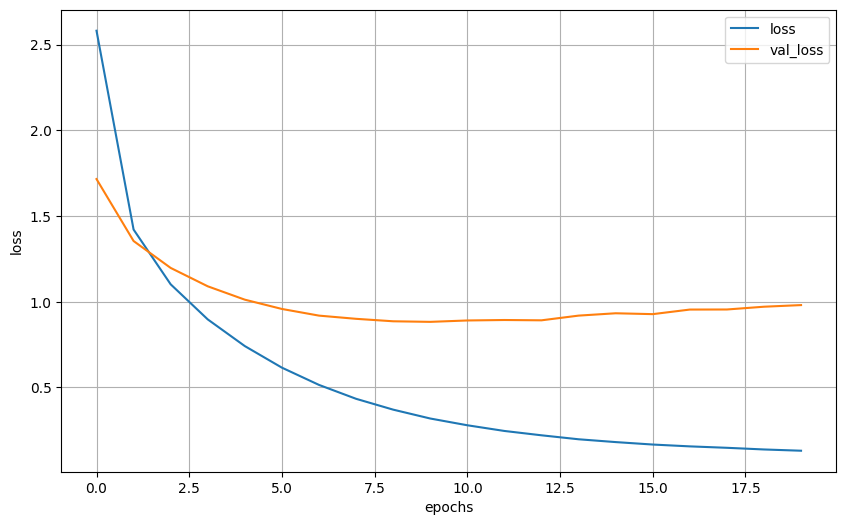

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

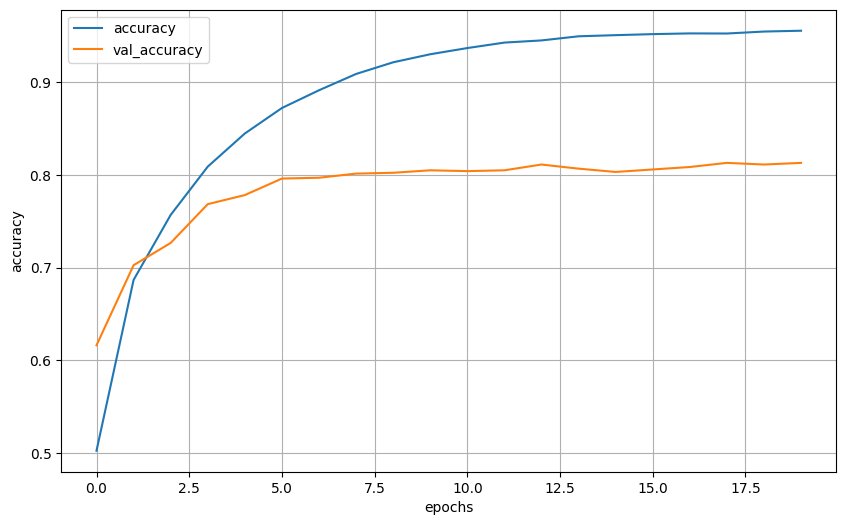

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [20]:
model.evaluate(X_test, Y_test)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7883 - loss: 1.0301


[0.9713731408119202, 0.7925200462341309]

In [22]:
model.predict(X_test).round(0)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)